<a href="https://colab.research.google.com/github/ianomunga/vectorgram/blob/main/vectorgramCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# system related
import os
import sys

# path manipulation
from pathlib import Path

# regex
import re

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle

# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image manipulation
from PIL import Image
#from IPython.display import Image [commenting out to resolve some inconsistency with PIL.Image]

# metrics
from sklearn.metrics import confusion_matrix, classification_report

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle

# keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
class MammoScan:
    def __init__(self, scan, sc_info):
        self.__scan = scan
        self.__sc_info = sc_info
    
    @property # scan image
    def scan(self):
        return self.__scan
    
    @property # scan info
    def scan_info(self):
        return self.__sc_info
    
    @property # from the scan file name
    def scan_name(self):
        return self.__sc_info.name
    
    @property # x coordinate of the abnormality
    def x(self):
        return self.__sc_info.x
    
    @property # y coordinate of the abnormality
    def y(self):
        return self.__sc_info.y
    
    @property # radius of the abnormality
    def radius(self):
        return self.__sc_info.radius

    @property # class of the abnormality
    def ab_class(self):
        return self.__sc_info.ab_class
    
    @property # background tissue of the abnormality
    def bg(self):
        return self.__sc_info.bg
    
    @property # severity of the abnormality
    def severity(self):
        return self.__sc_info.severity

    @property 
    # generates cropped downsized rotated images of the abnormality
    def transformations(self):
        return self.__transform()
    
    @property
    # returns the matricial representation fo the scan image
    def pixel_matrix(self):
        return np.array(self.scan)
    
    # instance method
    def plot(self):

        # Create a figure. Equal aspect so circles look circular
        fig, ax = plt.subplots(1)

        fig.set_size_inches(8, 6)
        ax.set_aspect('equal')

        # Show the image
        ax.imshow(self.scan, cmap=plt.cm.gray_r)
        ax.set_ylim(bottom=0, top=1024)
        ax.set_title(self.scan_name)
        

        # create a circle to patch on the image
        x, y, r = self.__get_crop_coords()
        print(f'{x}, {y}, {r}')
        circ = Circle((x,y), r, fill=False)
        ax.add_patch(circ)
    
    # private method
    def __set_x(self, xValue):
        self.__sc_info.x = xValue
    
    # private method
    def __set_y(self, yValue):
        self.__sc_info.y = yValue
    
    # private method
    def __set_radius(self, rValue):
        self.__sc_info.radius = rValue
        
    # private method
    def __get_crop_coords(self):
        '''Returns a tuple with x, y and r'''
        # check scan class to decide on how to crop
        if pd.isnull(self.radius):
            radius = 48.0
            self.__set_radius(radius)
        if pd.isnull(self.x):
            x = float(np.random.randint(500, 513))
            self.__set_x(x)
        if pd.isnull(self.y):
            y = float(np.random.randint(500, 513))
            self.__set_y(y)
            
        return (self.x, 1024.0-self.y, self.radius)
    
    # private method
    def __transform(self):
        '''Creates a dict 
                  with rotated and mirrored versions of self.scan'''
        # create dictionary
        transformations = dict()
        # get crop values
        x, y, r = self.__get_crop_coords()
        # crop and resize scan
        cropped_scan = self.scan.crop((x-r, y-r, x+r, y+r))
        resized_scan = cropped_scan.resize((48,48))
        # create rotated images
        for angle in (0, 90, 180, 270):
            rotated = resized_scan.rotate(angle) # rotated by angle
            mirr_tp = rotated.transpose(Image.FLIP_TOP_BOTTOM)
            mirr_lr = rotated.transpose(Image.FLIP_LEFT_RIGHT)
            
            transformations[angle] = dict(zip(['rotated', 'mirr_lr', 'mirr_tp'], 
                                              [rotated, mirr_lr, mirr_tp]))

        return transformations

In [ ]:
# helpers.py

# helper functions

import os
import pandas as pd
import numpy as np
import re
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def clean_ds_files(df: pd.DataFrame) -> pd.DataFrame:
    '''Removes records with invalid data
         and cast x and y to float'''
    new_df = df.copy()
    # search for invalid x values for removal
    indices = new_df.x[lambda x: x == '*NOTE'].index
    
    for idx in indices:
        n_idx = new_df.index.get_loc(idx)
        # drop from dataset
        new_df.drop(new_df.index[n_idx], inplace=True)
        # delete from directory
        delete_image(idx)

    # make x and y float values
    new_df.x = new_df.x.astype(float)
    new_df.y = new_df.y.astype(float)
    
    return new_df


def delete_image(filename: str, directory='../all-mias/'):
    '''Deletes original image files that won't be initially used'''
    paths = Path(directory).glob('**/*.pgm')
    filename += '.pgm'
    for f_path in sorted(paths):
        try:
            if f_path.name == filename:
                os.remove(f_path)
                break
        except FileNotFoundError as fnf:
            print('{fnf}') 
            
            
def create_scan_filenames_dic(path: str) -> dict:
    '''Creates a dictionary with image filenames'''
    paths = Path(path).glob('**/*.pgm')
    img_dic = dict()
    for f_path in sorted(paths):
        # get full filename
        full_fname = f_path.name
        # get filename (no extension)
        filename = f_path.stem
        # create dictionary
        img_dic[filename] = f_path.as_posix()
    
    return img_dic
        

def save_subsamples(scans_dic: dict(), df: pd.DataFrame) -> pd.DataFrame:
    '''Save subsamples to the subsamples folder'''
    # define subsamples folder
    folder = '../subsamples'
    df_sub = pd.DataFrame()
    try:
        # create if not yet
        if not os.path.exists(folder):
            os.mkdir(folder)
    except:
        print('An error occurred when searching for the folder')
        
    # iterate dictionary of filenames
    for scan_name, filename in scans_dic.items():
        
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = df.loc[scan_name].copy()
        # create the MammoScan object
        m_scan = MammoScan(scan, scan_info)
        # get the transformations
        transf_scans = m_scan.transformations
        # create filenames
        filenames = create_subsample_filename(scan_name, transf_scans)
        # get transformed scans Image objects
        imgs = get_transformed_scans(transf_scans)
        # prepare for saving
        fs_and_is = list(zip(filenames, imgs))
        
        for filename, image in fs_and_is:
            # create new observation with subsample name
            # name the series to become an index in the new dataframe
            scan_info.name = re.match(r'(.*)\.[^.]+$', filename).group(1)
            # create pixel matrix
            pixel_matrix = np.asarray(image)
            
            scan_info['p_matrix'] = pixel_matrix
            
            scan_info['subsample_path'] = os.path.join('../subsamples', filename)

            # append to dataframe
            df_sub = df_sub.append(scan_info.loc[['ab_class', 'bg', 
                                                  'severity', 'subsample_path',
                                                  'p_matrix']])
            
            #print(scan_name)
            path = os.path.join('../subsamples', filename) 
            #print(path)
            try:
                image.save(path, compress_level=0)
            except ValueError as ve:
                print('Output format could not be determined from the file name.')
            except OSError as ose:
                print('File could not be written.')
                print({ose})
        
    return df_sub


def create_subsample_filename(scan_name: str, transf_dic: dict) -> list:
    '''Creates suffix pattern filename for transformed scans'''
    filename = ''
    file_names = list()
    for angle, transfs in transf_dic.items():
        for tf in transfs.keys():
            filename += f'{scan_name}_{angle}_{tf}.png'
            #print(filename)
            file_names.append(filename)
            filename = ''
            
    return file_names


def get_transformed_scans(transf_dic: dict) -> list:
    scans = list()
    for angle, transfs in transf_dic.items():
        for scan in transfs.values():
            scans.append(scan)
    
    return scans


def generate_subsamples(path_to_originals: str, mias_df: pd.DataFrame) -> pd.DataFrame:
    ''' Generates the subsamples for training and testing.
        Files are saved in ../subsamples
        it returns a dataframe with the path to each subsample '''
    scans_filenames_dic = create_scan_filenames_dic(path_to_originals)
    final = save_subsamples(scans_filenames_dic, mias_df)
    return final


def balance_by_severity(df: pd.DataFrame, ab_class: str) -> pd.DataFrame:
    ''' Balances an abnormality class based on severity '''
    # deep copy
    df = df.copy()
    # if class == NORM, reduce norm to the avg class sample amount
    if ab_class == 'NORM':
        avg = int(df[df.ab_class != 'NORM'].groupby(['ab_class']).severity.size().mean())
        return df[(df.ab_class == ab_class)].sample(avg)   
    
    sev_counts = df[df.ab_class== ab_class].severity.value_counts()
    n_benign = sev_counts.loc['B']
    n_malign = sev_counts.loc['M']
    
    if n_benign > n_malign:
        # downsize 'B'
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')].sample(n_malign, replace=False)
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')]
    else:
        benign = df[(df.ab_class == ab_class) & (df.severity == 'B')]
        malign = df[(df.ab_class == ab_class) & (df.severity == 'M')].sample(n_benign, replace=False)
        
    return pd.concat([benign, malign])


def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    mammo.set_index(keys='refnum', drop=True, inplace=True)
    # return clean df and delete unuseful images
    return clean_ds_files(mammo)

def plot_results(acc,val_acc,loss, val_loss):
    # create grit
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6),
                                   sharex =True)
    
    # set plots
    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')
    
    
    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')
    plt.tight_layout()
    plt.show()
    
    
def balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        class_df = balance_by_severity(df, ab_class)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)


def full_balance_df_by_severity(df: pd.DataFrame) -> pd.DataFrame:
    final_df = pd.DataFrame()
    for ab_class in df.ab_class.unique():
        if ab_class == 'NORM':
            class_df = balance_by_severity(df, ab_class).sample(96, replace = False)
        else:
            class_df = balance_by_severity(df, ab_class)
            class_df_B = class_df[class_df.severity == 'B'].sample(48, replace = False)
            class_df_A = class_df[class_df.severity == 'M'].sample(48, replace = False)
            class_df = pd.concat([class_df_A, class_df_B])
            class_df = class_df.sample(len(class_df), replace = False)
        final_df = pd.concat([class_df, final_df])
        
    return final_df.sample(len(final_df), replace = False)

def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')
        
def create_final_results_df() -> pd.DataFrame:
    # create dataframe for results
    data = {"calcifications": [0, 0, 0, 0]}
    return pd.DataFrame.from_dict(data, orient='index', columns=['test_accuracy', 'precision','recall', 'f1-score'])

In [ ]:
#Load the data from GoogleDrive
mias = create_mias_dataset('/content/drive/MyDrive/vectorgram/Data/Info.txt')
mias

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,A,NaN,NaN,NaN
mdb319,D,NORM,A,NaN,NaN,NaN
mdb320,D,NORM,A,NaN,NaN,NaN


In [ ]:
#preprocess to remove faulty scans
mias = generate_subsamples('/content/drive/MyDrive/vectorgram/Data/all-mias', mias)

In [ ]:
mias

,ab_class,bg,severity,subsample_path,p_matrix
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png,"[[1, 4, 6, 9, 12, 15, 18, 24, 29, 35, 41, 48, ..."
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png,"[[121, 105, 113, 127, 136, 141, 139, 141, 142,..."
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 6, 7, 8, 10, 1..."
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png,"[[121, 110, 96, 98, 98, 99, 107, 130, 139, 127..."
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png,"[[62, 74, 77, 74, 75, 90, 109, 115, 125, 116, ..."
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,A,../subsamples/mdb322_180_mirr_lr.png,"[[197, 202, 202, 198, 196, 202, 207, 210, 211,..."
mdb322_180_mirr_tp,NORM,D,A,../subsamples/mdb322_180_mirr_tp.png,"[[207, 206, 206, 205, 203, 205, 207, 204, 200,..."
mdb322_270_rotated,NORM,D,A,../subsamples/mdb322_270_rotated.png,"[[197, 199, 198, 195, 196, 198, 197, 199, 200,..."
mdb322_270_mirr_lr,NORM,D,A,../subsamples/mdb322_270_mirr_lr.png,"[[177, 176, 175, 175, 179, 178, 177, 178, 177,..."


In [ ]:
#check proportions of each class distribution
mias.groupby(['ab_class']).severity.value_counts() / len(mias.index)

ab_class  severity
ARCH      M           0.031056
          B           0.027950
ASYM      M           0.027950
          B           0.018634
CALC      M           0.040373
          B           0.037267
CIRC      B           0.059006
          M           0.012422
MISC      B           0.021739
          M           0.021739
NORM      A           0.642857
SPIC      B           0.034161
          M           0.024845
Name: severity, dtype: float64

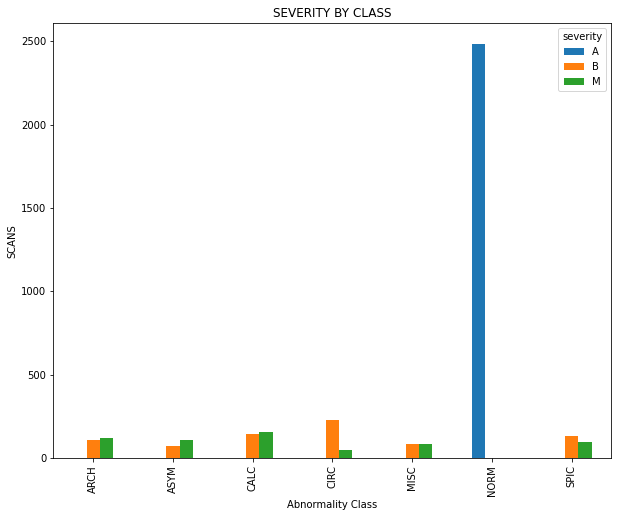

In [ ]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                               figsize=(10, 8), 
                                                               xlabel='Abnormality Class', 
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS');

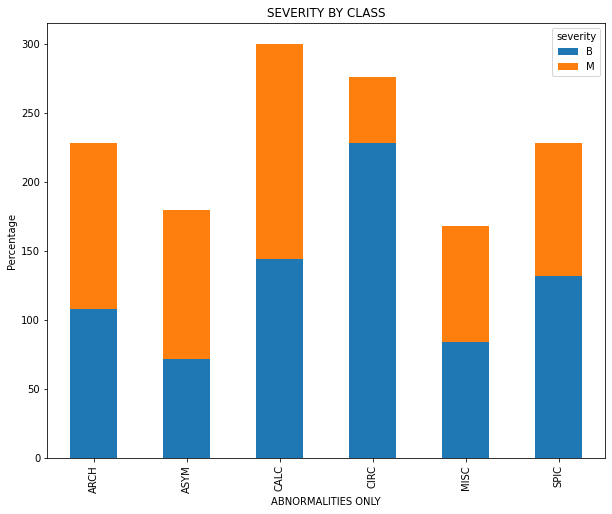

In [ ]:
mias[mias.ab_class != 'NORM'].groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                                                      stacked=True, 
                                                                                      figsize=(10, 8), 
                                                                                      xlabel='ABNORMALITIES ONLY', 
                                                                                      ylabel='Percentage',
                                                                                      title='SEVERITY BY CLASS');


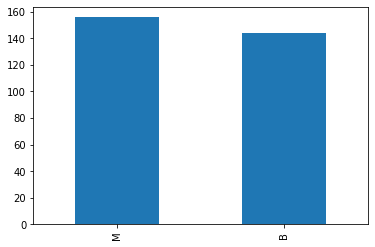

In [ ]:
#balancing calcifications data
calcifications_unbalanced = mias[mias.ab_class == 'CALC']

calcifications_unbalanced.severity.value_counts().plot(kind='bar');

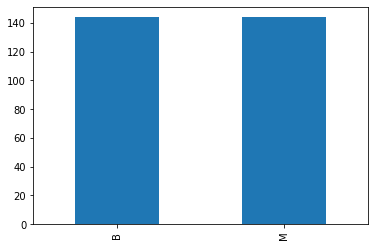

In [ ]:
#after they're all balanced
calcifications_balanced = balance_by_severity(mias, 'CALC')

calcifications_balanced.severity.value_counts().plot(kind='bar');

In [ ]:
final_results = create_final_results_df()

In [ ]:
#Training for Calcifications
calcifications = balance_by_severity(mias, 'CALC')
calcifications

,ab_class,bg,severity,subsample_path,p_matrix
mdb212_0_rotated,CALC,G,B,../subsamples/mdb212_0_rotated.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_lr,CALC,G,B,../subsamples/mdb212_0_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_0_mirr_tp,CALC,G,B,../subsamples/mdb212_0_mirr_tp.png,"[[3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_rotated,CALC,G,B,../subsamples/mdb212_90_rotated.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
mdb212_90_mirr_lr,CALC,G,B,../subsamples/mdb212_90_mirr_lr.png,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
...,...,...,...,...,...
mdb245_180_mirr_tp,CALC,F,M,../subsamples/mdb245_180_mirr_tp.png,"[[164, 162, 165, 164, 164, 168, 170, 169, 170,..."
mdb209_270_mirr_tp,CALC,G,M,../subsamples/mdb209_270_mirr_tp.png,"[[125, 120, 116, 120, 124, 134, 132, 133, 132,..."
mdb213_270_rotated,CALC,G,M,../subsamples/mdb213_270_rotated.png,"[[127, 125, 126, 129, 127, 129, 123, 115, 130,..."
mdb231_270_rotated,CALC,F,M,../subsamples/mdb231_270_rotated.png,"[[125, 126, 126, 128, 127, 127, 131, 136, 139,..."


In [ ]:
calcifications = calcifications.sample(len(calcifications), replace=False)

In [ ]:
#Generating Augmented Training and Test Data
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)

# train data
train_data = data_generator.flow_from_dataframe(calcifications, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)

# test data
test_data = data_generator.flow_from_dataframe(calcifications, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 216 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


In [ ]:
#Define CNN
cnn_calc = Sequential()
# first layer
cnn_calc.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))

cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))
cnn_calc.add(Dropout(0.25))
# Add dense layer to reduce the number of features
cnn_calc.add(Dense(64, activation='relu'))
cnn_calc.add(Dropout(0.25))
# flattening results
cnn_calc.add(Flatten())
# Dense layer to produce final output
cnn_calc.add(Dense(2, activation='softmax'))
# print summary
cnn_calc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 10, 10, 64)       

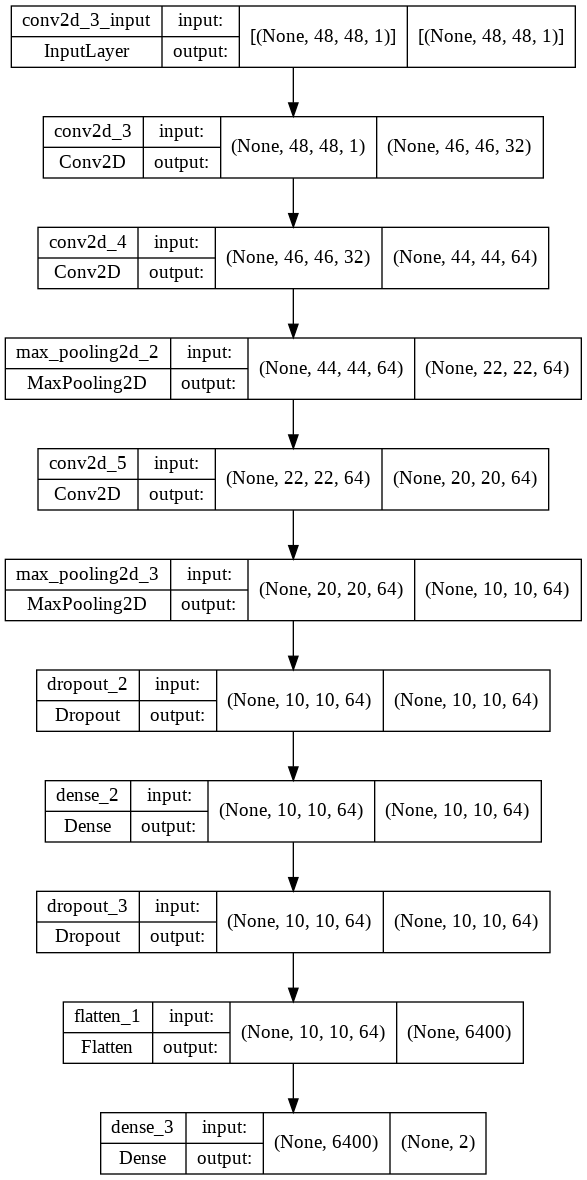

In [ ]:
#Visualize the CNN's structure
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image.open(fp = 'convnet.png')

In [ ]:
#Compiling the Model to parameter convergence by Adam
adam = Adam(0.001)
cnn_calc.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
#train and evaluate the model
# set callbacks
early_stopping = EarlyStopping(patience=10000, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist = cnn_calc.fit(train_data, 
                    validation_data=test_data, 
                    epochs=10000,
                    callbacks=[early_stopping, model_check_point])

Streaming output truncated to the last 5000 lines.
7/7 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9954
Epoch 8751: val_loss did not improve from 0.00159
7/7 [==============================] - 0s 62ms/step - loss: 0.0095 - accuracy: 0.9954 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 8752/10000
7/7 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9954
Epoch 8752: val_loss did not improve from 0.00159
7/7 [==============================] - 0s 70ms/step - loss: 0.0156 - accuracy: 0.9954 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 8753/10000
6/7 [========================>.....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 8753: val_loss did not improve from 0.00159
7/7 [==============================] - 0s 70ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 8754/10000
6/7 [========================>.....] - ETA: 0s - loss: 0.0196 - accuracy: 0.9946
Epoch 8754: val_loss did not improve fro

In [ ]:
#Making Predictions
predictions = cnn_calc.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = cnn_calc.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

7/7 [==============================] - 0s 31ms/step - loss: 0.0097 - accuracy: 1.0000
Test loss_value: 0.009662914089858532
Test accuracy: 1.0


In [ ]:
#Confusion Matrix
confusion_matrix(expected, predicted)

array([[34,  0],
       [ 1, 37]])

In [ ]:
#Classification Report
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.97      0.99        38

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



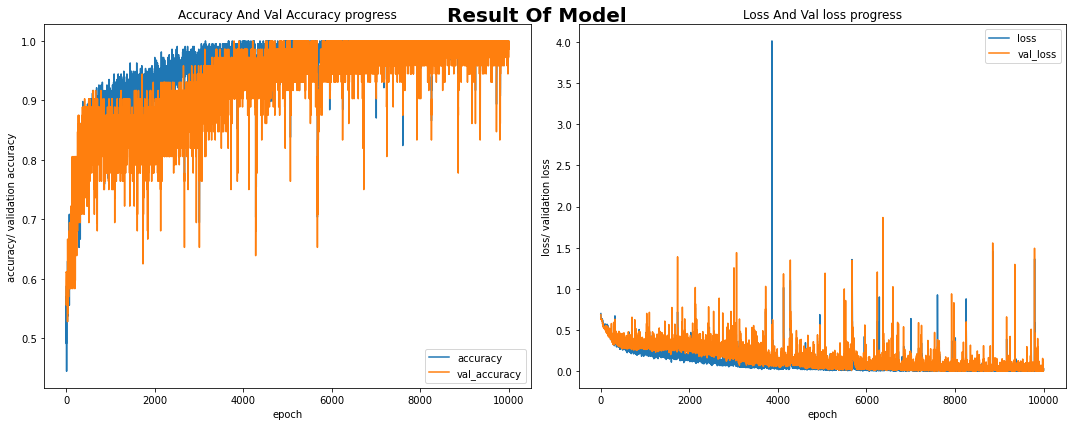

In [ ]:
#plotting the results
results_plot = plot_results(hist.history['accuracy'],
                            hist.history['val_accuracy'], 
                            hist.history['loss'], 
                            hist.history['val_loss'])

# enter data to the final results dataframe
results_calc = classification_report(expected, predicted, output_dict=True)

In [ ]:
calc_malignant = results_calc['1']
calc_malignant
final_results.loc['calcifications'] = (accuracy,
                                       calc_malignant['precision'], 
                                       calc_malignant['recall'], 
                                       calc_malignant['f1-score'])
final_results

,test_accuracy,precision,recall,f1-score
calcifications,1.0,1.0,0.973684,0.986667


In [ ]:
# checking wrong predictions
wrong_predictions = []
images = calcifications.p_matrix
predictions = cnn_calc.predict(test_data)

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)

    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

38

In [ ]:
a,b,c,d = wrong_predictions[4]

In [ ]:
display_probabilities(predictions[4])

0: 100.0000000000%
1: 0.0000000000%


In [ ]:
cnn_calc.get_weights()

In [ ]:
cnn_calc.summary()

In [ ]:
#saves the architecture, weights, training config [loss, optimizer] and the optimizer's state 
if os.path.isfile('/content/drive/MyDrive/vectorgram/Data/models/vectorgramCNNReg.h5') is False:
  cnn_calc.save('/content/drive/MyDrive/vectorgram/Data/models/vectorgramCNNReg.h5')

In [ ]:
from tensorflow.keras.models import load_model
vectorgramCNNReg = load_model('/content/drive/MyDrive/vectorgram/Data/models/vectorgramCNNReg.h5')

#serialize the model into a pickle file
import pickle
#this is the regularized model, with 98-ish percent scores instead of an overfit 100
model = vectorgramCNNReg
with open('/content/drive/MyDrive/vectorgram/Data/models/vectorgramCNNReg_pkl', 'wb') as files:
    pickle.dump(model, files)

INFO:tensorflow:Assets written to: ram://3280f5a2-bf01-4846-98b6-de56d0156fe7/assets


In [ ]:
from tensorflow.keras.models import load_model
vectorgramCNNReg = load_model('/content/drive/MyDrive/vectorgram/Data/models/vectorgramCNNReg.h5')